**Data Modeling - Random Forest**

In [ ]:
import rpy2
import pandas as pd 
import numpy as np
import os 
import random
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler

#!pip install sklearn
df = pd.read_csv('ExportedSubsetData.csv')
#Print data frame
df
#Dataset Info Summary
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   step            50000 non-null  int64  
 1   type            50000 non-null  object 
 2   amount          50000 non-null  float64
 3   nameOrig        50000 non-null  object 
 4   oldbalanceOrg   50000 non-null  float64
 5   newbalanceOrig  50000 non-null  float64
 6   nameDest        50000 non-null  object 
 7   oldbalanceDest  50000 non-null  float64
 8   newbalanceDest  50000 non-null  float64
 9   isFraud         50000 non-null  int64  
 10  isFlaggedFraud  50000 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 4.2+ MB


**1. Data Cleaning**

In [ ]:
# 1.1 - Removing Variables not needed for Calssification
newData = df.drop(['isFlaggedFraud', 'nameOrig', 'nameDest'], axis=1)
newData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   step            50000 non-null  int64  
 1   type            50000 non-null  object 
 2   amount          50000 non-null  float64
 3   oldbalanceOrg   50000 non-null  float64
 4   newbalanceOrig  50000 non-null  float64
 5   oldbalanceDest  50000 non-null  float64
 6   newbalanceDest  50000 non-null  float64
 7   isFraud         50000 non-null  int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 3.1+ MB


In [ ]:
# 1.2 - Retaining only CASH-OUT and TRANSFER transactions
newData = newData.loc[newData['type'].isin(['CASH_OUT', 'TRANSFER']),:]
print('The new data now has', len(newData), ' transations.')

The new data now has 21879  transations.


In [ ]:
# 1.3 - Converting categorical varaible to numeric representation
# Encoding categorical "type" variable to convert transation type to binary variables
newData = pd.get_dummies(newData, columns=['type'], prefix=['type'])
newData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21879 entries, 0 to 49999
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   step            21879 non-null  int64  
 1   amount          21879 non-null  float64
 2   oldbalanceOrg   21879 non-null  float64
 3   newbalanceOrig  21879 non-null  float64
 4   oldbalanceDest  21879 non-null  float64
 5   newbalanceDest  21879 non-null  float64
 6   isFraud         21879 non-null  int64  
 7   type_CASH_OUT   21879 non-null  uint8  
 8   type_TRANSFER   21879 non-null  uint8  
dtypes: float64(5), int64(2), uint8(2)
memory usage: 1.4 MB


In [ ]:
# Print first 5 rows
newData.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,type_CASH_OUT,type_TRANSFER
0,182,129804.96,0.00,0.0,4225880.68,4355685.64,0,1,0
4,252,61214.57,0.00,0.0,364102.11,425316.68,0,1,0
5,18,125379.52,0.00,0.0,883177.46,1120071.12,0,1,0
6,331,30449.41,0.00,0.0,456924.04,487373.45,0,1,0
7,277,157649.53,7660.25,0.0,491363.14,649012.67,0,1,0


In [ ]:
# To check min value of a feature. For Example:
newData['step'].min()

1

In [ ]:
# To check max value of a feature. For Example:
newData['step'].max()

742

**2. Data Normalization**

In [ ]:
# 2.1 (a) - Standardizing the Data or Scale Data using MinMaxScaler to convert the value between the min and max
# https://www.youtube.com/watch?v=sFVxFCYiIQI (15:00)
from sklearn.preprocessing import MinMaxScaler
scale_vars = ['step','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','isFraud' ]
scaler = MinMaxScaler()
newData[scale_vars] = scaler.fit_transform(newData[scale_vars])
newData.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,type_CASH_OUT,type_TRANSFER
0,0.244265,0.003076,0.000000,0.0,0.026917,0.027718,0.0,1,0
4,0.338731,0.001450,0.000000,0.0,0.002319,0.002707,0.0,1,0
5,0.022942,0.002971,0.000000,0.0,0.005626,0.007128,0.0,1,0
6,0.445344,0.000721,0.000000,0.0,0.002910,0.003102,0.0,1,0
7,0.372470,0.003736,0.000175,0.0,0.003130,0.004130,0.0,1,0


In [ ]:
# 2.1 (b) - Data Normalization using the Min-Max Method 
normalized_df = newData.copy()

for column in normalized_df.columns:
  normalized_df[column] = (normalized_df[column] - normalized_df[column].min())/(normalized_df[column].max() - normalized_df[column].min())
normalized_df.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,type_CASH_OUT,type_TRANSFER
0,0.244265,0.003076,0.000000,0.0,0.026917,0.027718,0.0,1.0,0.0
4,0.338731,0.001450,0.000000,0.0,0.002319,0.002707,0.0,1.0,0.0
5,0.022942,0.002971,0.000000,0.0,0.005626,0.007128,0.0,1.0,0.0
6,0.445344,0.000721,0.000000,0.0,0.002910,0.003102,0.0,1.0,0.0
7,0.372470,0.003736,0.000175,0.0,0.003130,0.004130,0.0,1.0,0.0


In [ ]:
# 2.1 (c) Standardizing the Data: converting all columns to have the same range
# Normalization of dataset
std_scaler = StandardScaler()
data_scaled = pd.DataFrame(std_scaler.fit_transform(newData.loc[:,~newData.columns.isin(['isFraud'])]))
data_scaled.columns = newData.columns[:-1]
data_scaled['isFraud'] = newData['isFraud']

In [ ]:
# To validate min value of a feature has been converted. For Example:
newData['step'].min()

0.0

In [ ]:
# To validate max value of a feature has been converted. For Example:
newData['step'].max()

0.9999999999999999

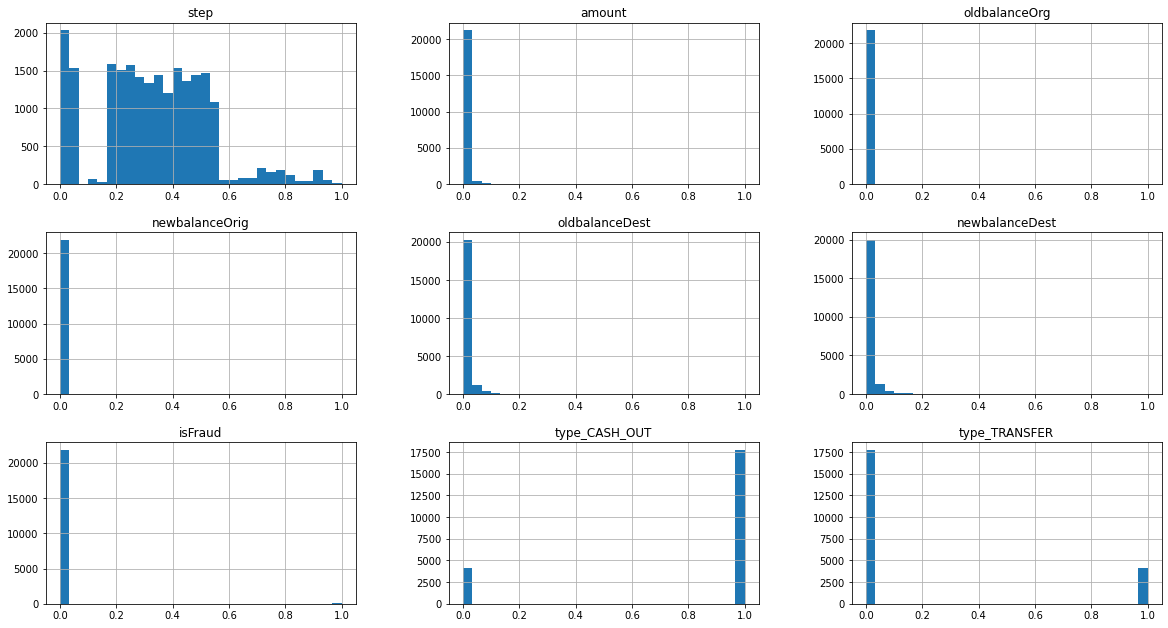

In [ ]:
# 2.2 - Visualize distributions
newData.hist(bins=30, figsize=(20,30), layout=(8,3));

In [ ]:
# 2.3 - Transformation of Independent Variables with visually non-normal distributions 
normalized_df[['step', 
         'amount',
         'oldbalanceOrg',
         'newbalanceOrig',
         'oldbalanceDest',
         'newbalanceDest',
         'isFraud']] = normalized_df[['step', 
         'amount',
         'oldbalanceOrg',
         'newbalanceOrig',
         'oldbalanceDest',
         'newbalanceDest',
         'isFraud']].applymap(lambda x: np.log(1+x))

normalized_df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,type_CASH_OUT,type_TRANSFER
count,21879.000000,21879.000000,21879.000000,21879.000000,21879.000000,21879.000000,21879.000000,21879.000000,21879.000000
mean,0.271409,0.007560,0.001104,0.000364,0.010620,0.012774,0.002154,0.810046,0.189954
std,0.144908,0.019878,0.006662,0.005033,0.022766,0.025241,0.038583,0.392273,0.392273
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.188823,0.001944,0.000000,0.000000,0.000867,0.002119,0.000000,1.000000,0.000000
50%,0.275462,0.004021,0.000006,0.000000,0.003567,0.005284,0.000000,1.000000,0.000000
75%,0.370213,0.007182,0.000701,0.000000,0.011085,0.013629,0.000000,1.000000,0.000000
max,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,1.000000,1.000000


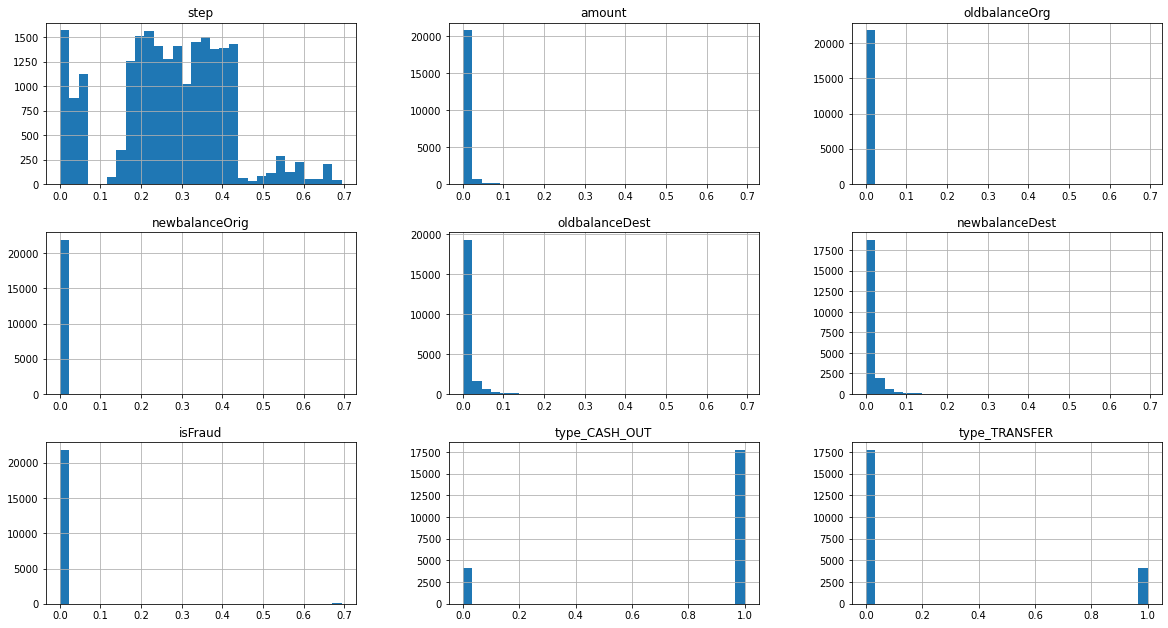

In [ ]:
# Visualize distributions
normalized_df.hist(bins=30, figsize=(20,30), layout=(8,3));

**3. Create Train and Test Datasets**

In [ ]:
# 3.1 - Split the scaled cleaned dataset into 70%  training and 30% testing datasets
# https://www.datacamp.com/tutorial/understanding-logistic-regression-python
# Model building in Scikit-learn
# Split dataset into feature (independant variable) and target variable (isFraud)
feature_cols = ['step','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','type_CASH_OUT','type_TRANSFER']
X = newData[feature_cols] # Features
y = newData.isFraud # Target variable

# Split X and y into training and testing datasets
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=0)

In [ ]:
# 3.2 - SMOT
# https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

sm = SMOTE(random_state=25, sampling_strategy=1.0)
X_train, y_train = sm.fit_resample(X_train, y_train)

**4. Setup Random Forest Model**

In [ ]:
# 4.1 - Import and setup Random Forest Model
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 100, criterion = 'entropy')# Train the model on training data
rf.fit(X_train, y_train)
prediction_test = rf.predict(X=X_test)
#Y_pred = model.predict_generator(test_generator)
#y_pred = np.argmax(Y_pred, axis=1)

#Accuracy on Test
#print("Training Accuracy is: ", rf.score(X_train, y_train))
#Accuracy on Train
#print("Testing Accuracy is: ", rf.score(X_test, y_test))

#Conusion Matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
#cm = confusion_matrix(y_test, prediction_test)
#cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
#plt.figure()
#plot_confusion_matrix(cm_norm, classes=rf.classes_)

#cm = confusion_matrix(test_generator.classes, y_pred)
#plot_consution_matrix(X = test_generator.classes, y_true = y_pred,labels= category_names, normalize=False)

In [ ]:
# 4.2 - Import the metrics class
from sklearn import metrics
y_pred = classifier.predict(X_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[6534,   10],
       [   5,   15]])

Text(0.5, 257.44, 'Predicted label')

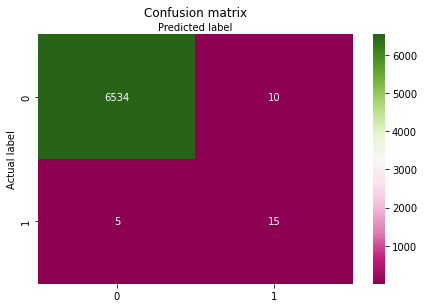

In [ ]:
# 4.3 - Visualizing Confusion Matrix using Heatmap
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="PiYG" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [ ]:
#Confusion Matrix Evaluation Metrics:  classification rate of 80%, considered as good accuracy.
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

#Well, you got a classification rate of 80%, considered as good accuracy.
#Precision: Precision is about being precise, i.e., how accurate your model is. In other words, you can say, when a model makes a prediction, how often it is correct. In your prediction case, when your Logistic Regression model predicted patients are going to suffer from diabetes, that patients have 76% of the time.
#Recall: If there are patients who have diabetes in the test set and your Logistic Regression model can identify it 58% of the time.

Accuracy: 0.9977148080438757
Precision: 0.6
Recall: 0.75


**5. Model Evaluation & Validation (TBD)**

In [ ]:
# 5.1 - Calculate Evaluation Metrics 
from sklearn import metrics
print('MAE', metrics.mean_absolute_error(y_test, y_pred))
print('R^2', metrics.r2_score(y_test, y_pred))
print('RMSE', metrics.mean_squared_error(y_test, y_pred))

MAE 0.0022851919561243145
R^2 0.24770782396088042
RMSE 0.0022851919561243145


/usr/local/lib/python3.7/dist-packages/statsmodels/nonparametric/smoothers_lowess.py:165: RuntimeWarning: invalid value encountered in true_divide
  res = _lowess(y, x, frac=frac, it=it, delta=delta)


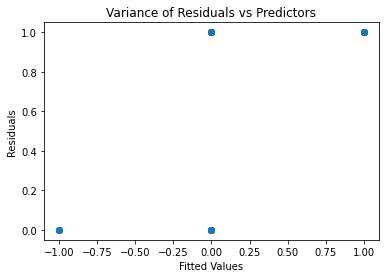

In [ ]:
# 5.2 - Plot residuals to determine variance 
residuals = y_pred - y_test 
sns.regplot(y=y_pred, x=residuals, lowess=True)
plt.title("Variance of Residuals vs Predictors")
plt.ylabel("Residuals")
plt.xlabel("Fitted Values")
plt.show()

*****Extra Codes for Reference**

In [ ]:
# Version 1: Create Train and Test Datasets: 70% for training and 30% for testing
# Check https://www.youtube.com/watch?v=sFVxFCYiIQI (16:20) Splitting Raw Data - X = exclude isFraud, y = isFraud only
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import LabelEncoder
X = data_scaled.loc[:, data_scaled.columns != 'isFraud']
y = data_scaled.loc[:, data_scaled.columns == 'isFraud']

X_train_original, X_test_original, y_train_original, y_test_original = train_test_split(X,y,test_size = 0.3, random_state = 0)

label_encoder = LabelEncoder()
y_train_original = label_encoder.fit_transform(y_train_original.values.ravel())
y_test_original = label_encoder.fit_transform(y_test_original.values.ravel())

In [ ]:
print('X shape:{}'.format(np.shape(X)))
print('y shape: {}'.format(np.shape(y)))

X shape:(21879, 7)
y shape: (21879, 1)


In [ ]:
# Version 2: Check https://www.youtube.com/watch?v=sFVxFCYiIQI (16:20) Splitting Raw Data - X = exclude isFraud, y = isFraud only
from sklearn.model_selection import train_test_split
X = newData.drop('isFraud', axis=1).values
y = newData['isFraud'].values
print('X shape:{}'.format(np.shape(X)))
print('y shape: {}'.format(np.shape(y)))

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, test_size = 0.3, random_state = 0)

X shape:(21879, 8)
y shape: (21879,)


In [ ]:
# 6. Check class imbalance in Train and Test Datasets
#Class Imbalance - Percentage Frequency
dFraud = pd.DataFrame(y_train, columns= ['isFraud'])
# Percentage calculation
(dFraud['isFraud'].value_counts()/dFraud['isFraud'].count())*100

0.0    50.0
1.0    50.0
Name: isFraud, dtype: float64

In [ ]:
#Class Imbalance - Percentage Frequency
dFraud = pd.DataFrame(y_test, columns= ['isFraud'])
# Percentage calculation
(dFraud['isFraud'].value_counts()/dFraud['isFraud'].count())*100

0.0    99.695308
1.0     0.304692
Name: isFraud, dtype: float64

**Classification Models for Fraud Detection**

In [ ]:
# Defining the Models: Random Forest
from sklearn.ensemble import RandomForestClassifier
accuracy_dict = {}
model_rf = RandomForestClassifier()

In [ ]:
# Stratified 5-fold cross-validation: to ensure models do not overfit the training data
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(5)

In [ ]:
# import the metrics class
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[5863,  681],
       [   6,   14]])

Text(0.5, 257.44, 'Predicted label')

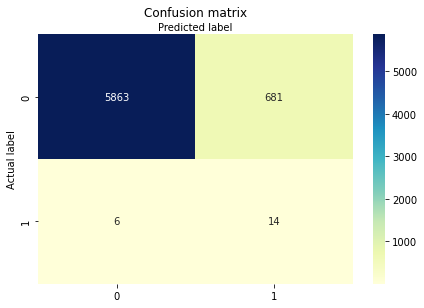

In [ ]:
#Visualizing Confusion Matrix using Heatmap
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

**Random Forrest - Version #1**

In [ ]:
# 4.2 - Testing the Model
y_pred = classifier.predict(X_test)

# importing accuracy score
from sklearn.metrics import accuracy_score

# printing the accuracy of the model
print(accuracy_score(y_test, y_pred))

#Accuracy on Test
print("Training Accuracy is: ", rf.score(X_train, y_train))
#Accuracy on Train
print("Testing Accuracy is: ", rf.score(X_test, y_test))

0.9977148080438757
Training Accuracy is:  1.0
Testing Accuracy is:  0.9974101157830592


In [ ]:
#Conusion Matrix
def plot_confusion_matrix(cm, classes=None, title='Confusion Matrix'):
  if classes is not None:
    sns.heatmap(cm, xticklables=classes, yticklables=classes, vmin=0., vmax=1., annot=True, annot_kws={'size':50})
  else:
    sns.heatmap(cm, vmin=1., vmax=1.)
  plt.title(title)
  plt.ylable('True Label')
  plt.xlabel('Predicted Label')

y_pred = rf.predict(X_train)
cm = confusion_matrix(y_test, prediction_test)
cm
#cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
#plt.figure()
#plot_confusion_matrix(cm_norm, classes=rf.classes_, title="Training Confusion")

array([[6534,   10],
       [   5,   15]])

**Random Forrest - Version #2**

In [ ]:
#Random Forrest: Version 2 https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

# Labels are the values we want to predict
#labels = np.array(features['actual'])
# Remove the labels from the features
# axis 1 refers to the columns
#features= features.drop('actual', axis = 1)
# Saving feature names for later use
#feature_list = list(features.columns)
# Convert to numpy array
#features = np.array(features)

#Should be same as Logistic Regression
feature_cols = ['step','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','type_CASH_OUT','type_TRANSFER']
X = newData[feature_cols] # Features
y = newData.isFraud # Target variable / Labels

# split X and y into training and testing sets
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=0)

print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (15315, 8)
Training Labels Shape: (15315,)
Testing Features Shape: (6564, 8)
Testing Labels Shape: (6564,)


In [ ]:
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 100, random_state = 42)
# Train the model on training data
rf.fit(X_train, y_train);

In [ ]:
# Use the forest's predict method on the test data
predictions = rf.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Mean Absolute Error: 0.0 degrees.
Accuracy: -inf %.


**Random Forrest - Verstion #3**

In [ ]:
# https://hands-on.cloud/implementation-of-random-forest-algorithm-using-python/
# import Random Forest classifier
from sklearn.ensemble import RandomForestClassifier

# instantiate the classifier 
classifier = RandomForestClassifier()

# fit the model
classifier.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
# predicting the outcome
#y_output = classifier.predict([[1, 333,44,55,6666,77777 19.43]])

# printing the output
#print(y_output)

In [ ]:
#Visualizing Confusion Matrix
# importing the required modules
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Plot the confusion matrix in graph
cm = confusion_matrix(y_test,y_pred, labels=classifier.classes_)

# ploting with labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
disp.plot()

# showing the matrix
plt.show()

ValueError: ignored

In [ ]:
# Random Forest Model
sc_rf = cross_val_score(model_rf, x_train_original, y_train_original, cv=skf, scoring=scr)